In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import folium
import numpy as np


plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
from IPython.display import display

In [47]:
df = pd.read_csv('data/df_mtv2loop.csv')
df.head()

,time,latitude,longitude,elevation,pointxyz,distance,mph,pace,sec_mile_pace,elevation_change,cum_elevation,cum_distance,second,elapsed_time,step_feet,moving_time
0,2021-11-19 14:52:53+00:00,38.796494,-77.045523,-3.0,"(38.79649353213608, -77.04552322626114, -3.0)",0.000000,0.000000,0,0.000000,0.0,0.0,0.000000,0,0:00:00,0.000000,0
1,2021-11-19 14:52:54+00:00,38.796489,-77.045519,-3.0,"(38.79648883827031, -77.04551886767149, -3.0)",0.000400,1.441224,0:41:37.876805,2497.876805,0.0,0.0,0.000400,1,0:00:01,2.113795,1
2,2021-11-19 14:52:55+00:00,38.796473,-77.045510,-3.0,"(38.796473080292344, -77.04550998285413, -3.0)",0.001189,4.281336,0:14:00.859022,840.859022,0.0,0.0,0.001590,2,0:00:02,6.279293,1
3,2021-11-19 14:52:56+00:00,38.796457,-77.045503,-3.0,"(38.79645690321922, -77.04550285823643, -3.0)",0.001182,4.254264,0:14:06.209826,846.209826,0.0,0.0,0.002771,3,0:00:03,6.239587,1
4,2021-11-19 14:52:57+00:00,38.796427,-77.045499,-2.8,"(38.796427231281996, -77.04549883492291, -2.79...",0.002062,7.421580,0:08:05.071912,485.071912,0.2,0.2,0.004833,4,0:00:04,10.884984,1


# Segments
 ### I want to assign a grade designation by some unit of distance (15 ft?  15 seconds? or consistant grade sticks together whether long or short?)
 
 ### I want to create a function that will find loops or will identify when you get back to start...
 ### I want to create segments @ natural stopping points (roads/lights/aid stations) where speed is close to 0. 
 ### do segments first, then get rid of the stopped areas (or just label them differently and can sum moving time by count and get "seconds
 ### cycle between moving seg1, stopped segment (i.e. time spent at aid or at light) and then after a stop then seg2 , and so on.

In [48]:
df.tail()

,time,latitude,longitude,elevation,pointxyz,distance,mph,pace,sec_mile_pace,elevation_change,cum_elevation,cum_distance,second,elapsed_time,step_feet,moving_time
4299,2021-11-19 16:04:32+00:00,38.795236,-77.045685,-21.6,"(38.7952355761081, -77.04568499699235, -21.600...",0.002137,7.694640,0:07:47.858145,467.858145,0.000000,-18.6,8.280211,4299,1:11:39,11.285472,1
4300,2021-11-19 16:04:33+00:00,38.795267,-77.045679,-21.6,"(38.79526692442596, -77.04567896202207, -21.60...",0.002190,7.884756,0:07:36.577223,456.577223,0.000000,-18.6,8.282401,4300,1:11:40,11.564309,1
4301,2021-11-19 16:04:34+00:00,38.795301,-77.045674,-21.6,"(38.79530120640993, -77.04567359760404, -21.60...",0.002386,8.590356,0:06:59.074599,419.074599,0.000000,-18.6,8.284787,4301,1:11:41,12.599189,1
4302,2021-11-19 16:04:35+00:00,38.795327,-77.045666,-21.6,"(38.79532660357654, -77.04566630534828, -21.60...",0.001798,6.473448,0:09:16.117852,556.117852,0.000000,-18.6,8.286586,4302,1:11:42,9.494390,1
4303,2021-11-19 16:04:36+00:00,38.795349,-77.045664,-21.4,"(38.79534940235317, -77.04566420987248, -21.39...",0.001579,5.685408,0:10:33.199939,633.199939,0.200001,-18.4,8.288165,4303,1:11:43,8.338598,1


In [49]:
full_miles = df['distance'].sum()//1
full_miles

8.0

In [50]:
# find the point that is at each mile completion.  we know how many miles it is.  
# find the cum miles that is closest to the whole numbers and label it/label all points as being part of x mile

def find_neighbours(value, df, colname):
    exactmatch = df[df[colname] == value]
    if not exactmatch.empty:
        return exactmatch.index
    else:
        lowerneighbour_ind = df[df[colname] < value][colname].idxmax()
        upperneighbour_ind = df[df[colname] > value][colname].idxmin()
        return [lowerneighbour_ind, upperneighbour_ind] 

junder,jover = find_neighbours(1,df,'cum_distance')
df[junder:jover+1]


,time,latitude,longitude,elevation,pointxyz,distance,mph,pace,sec_mile_pace,elevation_change,cum_elevation,cum_distance,second,elapsed_time,step_feet,moving_time
467,2021-11-19 15:00:40+00:00,38.785530,-77.054167,-13.6,"(38.78553017042577, -77.0541665609926, -13.600...",0.002179,7.844760,0:07:38.905053,458.905053,0.0,-10.6,0.999189,467,0:07:47,11.505648,1
468,2021-11-19 15:00:41+00:00,38.785499,-77.054173,-13.8,"(38.78549890592694, -77.05417267978191, -13.80...",0.002185,7.866576,0:07:37.632393,457.632393,-0.2,-10.8,1.001374,468,0:07:48,11.537645,1


In [51]:
print(df['cum_distance'][junder]//1)
print(df['cum_distance'][jover]//1)


0.0
1.0


In [52]:
# add mile indicators
def make_mile_segments(row):
    return row['cum_distance']//1 +1
df['mile_num'] = df.apply(make_mile_segments, axis=1)
df['mile_num'].unique()

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [53]:
# time_by_mile 
# change mile time to sec_to_time
def mile_time(mile):
    seconds = int(df[df['mile_num'] == mile]['second'].count())
    str_time = str(datetime.timedelta(seconds=seconds))
    return str_time
mile_time(1)

# for each mile find the mile time  
# change run_miles to mile_pace
def run_miles(df):
    mile_analysis=[]        
    for i in df['mile_num'].unique():
        if i == 0:
            continue
        else:
            mile_analysis.append(mile_time(i))
    return mile_analysis

# Start and finish location
start_loc = df['pointxyz'][0:1].values
end_loc = df[df['cum_distance'] == df['cum_distance'].max()]['pointxyz'].values

# find the end location of each mile
def mile_marker_loc(df):
    mile_markers = []

    for i in range(1,len(df['mile_num'].unique())):
        junder,jover  = find_neighbours(i, df, 'cum_distance')
        mile_markers.append(jover)
    return mile_markers

In [54]:
df[df['mile_num'] == 1]

,time,latitude,longitude,elevation,pointxyz,distance,mph,pace,sec_mile_pace,elevation_change,cum_elevation,cum_distance,second,elapsed_time,step_feet,moving_time,mile_num
0,2021-11-19 14:52:53+00:00,38.796494,-77.045523,-3.0,"(38.79649353213608, -77.04552322626114, -3.0)",0.000000,0.000000,0,0.000000,0.0,0.0,0.000000,0,0:00:00,0.000000,0,1.0
1,2021-11-19 14:52:54+00:00,38.796489,-77.045519,-3.0,"(38.79648883827031, -77.04551886767149, -3.0)",0.000400,1.441224,0:41:37.876805,2497.876805,0.0,0.0,0.000400,1,0:00:01,2.113795,1,1.0
2,2021-11-19 14:52:55+00:00,38.796473,-77.045510,-3.0,"(38.796473080292344, -77.04550998285413, -3.0)",0.001189,4.281336,0:14:00.859022,840.859022,0.0,0.0,0.001590,2,0:00:02,6.279293,1,1.0
3,2021-11-19 14:52:56+00:00,38.796457,-77.045503,-3.0,"(38.79645690321922, -77.04550285823643, -3.0)",0.001182,4.254264,0:14:06.209826,846.209826,0.0,0.0,0.002771,3,0:00:03,6.239587,1,1.0
4,2021-11-19 14:52:57+00:00,38.796427,-77.045499,-2.8,"(38.796427231281996, -77.04549883492291, -2.79...",0.002062,7.421580,0:08:05.071912,485.071912,0.2,0.2,0.004833,4,0:00:04,10.884984,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2021-11-19 15:00:36+00:00,38.785643,-77.054121,-13.8,"(38.785642739385366, -77.05412104725838, -13.8...",0.001945,7.002828,0:08:34.078027,514.078027,0.2,-10.8,0.991025,463,0:07:43,10.270814,1,1.0
464,2021-11-19 15:00:37+00:00,38.785616,-77.054134,-13.8,"(38.78561616875231, -77.0541335362941, -13.800...",0.001955,7.038720,0:08:31.456628,511.456628,0.0,-10.8,0.992981,464,0:07:44,10.323456,1,1.0
465,2021-11-19 15:00:38+00:00,38.785588,-77.054145,-13.6,"(38.785587921738625, -77.05414527095854, -13.6...",0.002051,7.385256,0:08:07.457713,487.457713,0.2,-10.6,0.995032,465,0:07:45,10.831709,1,1.0
466,2021-11-19 15:00:39+00:00,38.785561,-77.054157,-13.6,"(38.78556084819138, -77.05415717326105, -13.60...",0.001977,7.118604,0:08:25.717132,505.717132,0.0,-10.6,0.997010,466,0:07:46,10.440619,1,1.0


## Check the unit for the gradient sections etc

#### elevation breakdown per mile

In [65]:
el_up=[]
el_dwn = []
for i in range(len(df)):
    if df['elevation_change'][i]>=0:
        el_up.append(df['elevation_change'][i])
        el_dwn.append(0)

    else:
        el_dwn.append(df['elevation_change'][i])
        el_up.append(0)

df['el_up'] = pd.Series(el_up)
df['el_dwn'] = pd.Series(el_dwn)



In [66]:
df.head()

,time,latitude,longitude,elevation,pointxyz,distance,mph,pace,sec_mile_pace,elevation_change,cum_elevation,cum_distance,second,elapsed_time,step_feet,moving_time,mile_num,grade_section,el_up,el_dwn
0,2021-11-19 14:52:53+00:00,38.796494,-77.045523,-3.0,"(38.79649353213608, -77.04552322626114, -3.0)",0.000000,0.000000,0,0.000000,0.0,0.0,0.000000,0,0:00:00,0.000000,0,1.0,1.0,0.0,0.0
1,2021-11-19 14:52:54+00:00,38.796489,-77.045519,-3.0,"(38.79648883827031, -77.04551886767149, -3.0)",0.000400,1.441224,0:41:37.876805,2497.876805,0.0,0.0,0.000400,1,0:00:01,2.113795,1,1.0,1.0,0.0,0.0
2,2021-11-19 14:52:55+00:00,38.796473,-77.045510,-3.0,"(38.796473080292344, -77.04550998285413, -3.0)",0.001189,4.281336,0:14:00.859022,840.859022,0.0,0.0,0.001590,2,0:00:02,6.279293,1,1.0,1.0,0.0,0.0
3,2021-11-19 14:52:56+00:00,38.796457,-77.045503,-3.0,"(38.79645690321922, -77.04550285823643, -3.0)",0.001182,4.254264,0:14:06.209826,846.209826,0.0,0.0,0.002771,3,0:00:03,6.239587,1,1.0,1.0,0.0,0.0
4,2021-11-19 14:52:57+00:00,38.796427,-77.045499,-2.8,"(38.796427231281996, -77.04549883492291, -2.79...",0.002062,7.421580,0:08:05.071912,485.071912,0.2,0.2,0.004833,4,0:00:04,10.884984,1,1.0,1.0,0.2,0.0


In [64]:
# create an up colum and a down column
df.groupby(['mile_num'])['elevation_change'].sum()

mile_num
1.0   -10.600000
2.0    -3.799999
3.0    41.199999
4.0    -7.400000
5.0     8.400000
6.0   -46.199999
7.0    -2.600000
8.0     9.200000
9.0    -6.599999
Name: elevation_change, dtype: float64

#### back to gradient

In [56]:
# create an custom segment based on a unit - fraction of mile
def section_distance(df,unit):
    return df['cum_distance']//unit +1

df['grade_section'] = df.apply(section_distance,unit=.1, axis=1)


In [57]:
# find the starting location of the custom gradient segments
def grade_marker_loc(df):
    grade_markers = []
    for i in range(1,len(df['grade_section'].unique())):
        junder,jover  = find_neighbours(i/10, df, 'cum_distance')
        grade_markers.append(jover)
    return grade_markers



In [58]:
# find the gradient of the custom 'grade_section"
unit = 0.1
prev = df['elevation'][0]

# elevation is in Meters but distance is in miles. so convert the elevation into miles
conversion_factor = 0.62137119
gradient =[]

for i in range(len(df['grade_section'].unique())):
    el_diff = df['elevation'][i] - prev
    unit_gradient = el_diff/(unit/conversion_factor*1000)
    gradient.append(unit_gradient*100)
    prev = df['elevation'][i]

gradient[0:10]

[0.0,
 0.0,
 0.0,
 0.0,
 0.12427426762928723,
 0.24854838711213792,
 0.2485485352585747,
 0.0,
 0.0,
 0.0]

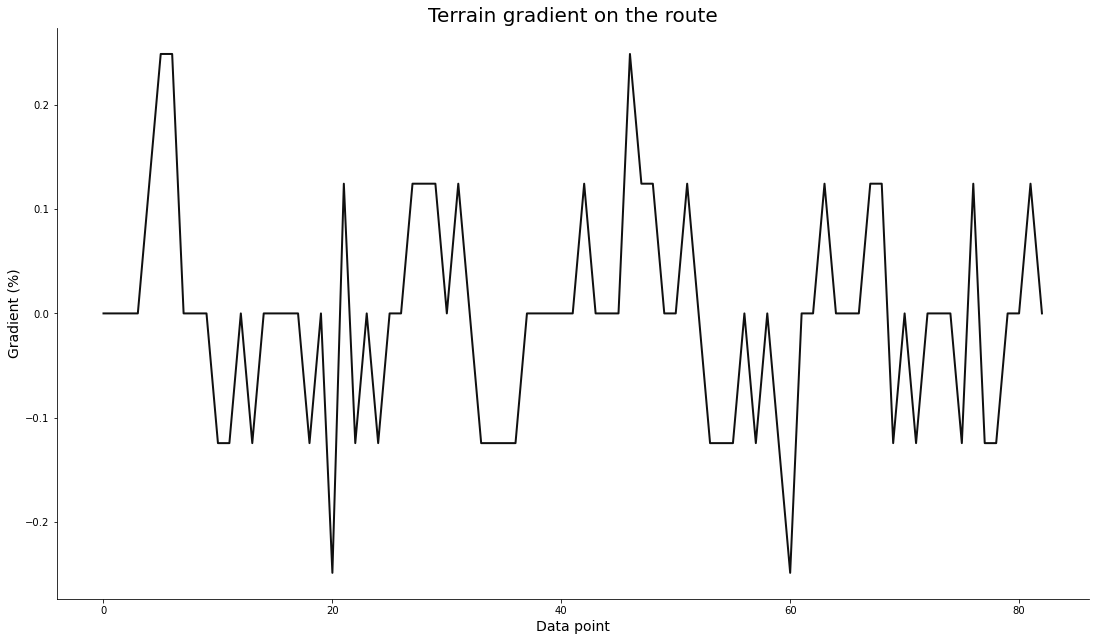

In [59]:


plt.figure(figsize=(18.5, 10.5))
plt.title('Terrain gradient on the route', size=20)
plt.xlabel('Data point', size=14)
plt.ylabel('Gradient (%)', size=14)
plt.plot(np.arange(len(gradient)), gradient, lw=2, color='#101010');

In [17]:
from folium.features import DivIcon

def number_DivIcon(color,number):
    """ Create a 'numbered' icon
    
    """
    icon = DivIcon(
            icon_size=(150,36),
            icon_anchor=(14,40),
#             html='<div style="font-size: 18pt; align:center, color : black">' + '{:02d}'.format(num+1) + '</div>',
            html="""<span class="fa-stack " style="font-size: 12pt" >>
                    <!-- The icon that will wrap the number -->
                    <span class="fa fa-circle-o fa-stack-2x" style="color : {:s}"></span>
                    <!-- a strong element with the custom content, in this case a number -->
                    <strong class="fa-stack-1x">
                         {:02d}  
                    </strong>
                </span>""".format(color,number)
        )
    return icon
    
col_hex = ['#440154',
 '#481a6c',
 '#472f7d',
 '#414487',
 '#39568c',
 '#31688e',
 '#2a788e',
 '#23888e',
 '#1f988b',
 '#22a884',
 '#35b779',
 '#54c568',
 '#7ad151',
 '#a5db36',
 '#d2e21b'
 ]

In [18]:
# Graph mile markers on map with mile time on click - folium
lat_map = df['latitude'].mean()
lon_map = df['longitude'].mean()
route_map = folium.Map(
    location=[lat_map, lon_map],
    zoom_start=14,
    tiles='OpenStreetMap',
    width= 1000,
    height=800
)
coordinates = [tuple(x) for x in df[['latitude','longitude']].to_numpy()]
folium.PolyLine(coordinates, weight=6).add_to(route_map)

# find mile markers
locations_to_chart = mile_marker_loc(df)
# find mile times
mile_times = run_miles(df)
num =0
mile=1

for i in locations_to_chart:
    mile_hex = mile//15+1
    loc = [df['latitude'][i], df['longitude'][i]]
    folium.Marker(
        location=loc,
        popup="Mile " + '{:02d}'.format(mile),
        icon=folium.Icon(color='white',icon_color='white'),
        markerColor=col_hex[mile_hex]
    ).add_to(route_map)

    folium.Marker(
        location=loc,
        popup="Mile " + '{:02d}'.format(mile)+ " "+ mile_times[mile-1],
        icon= number_DivIcon(col_hex[mile_hex],mile)
    ).add_to(route_map)
    mile+=1



display(route_map)

In [44]:
16//15+1

2

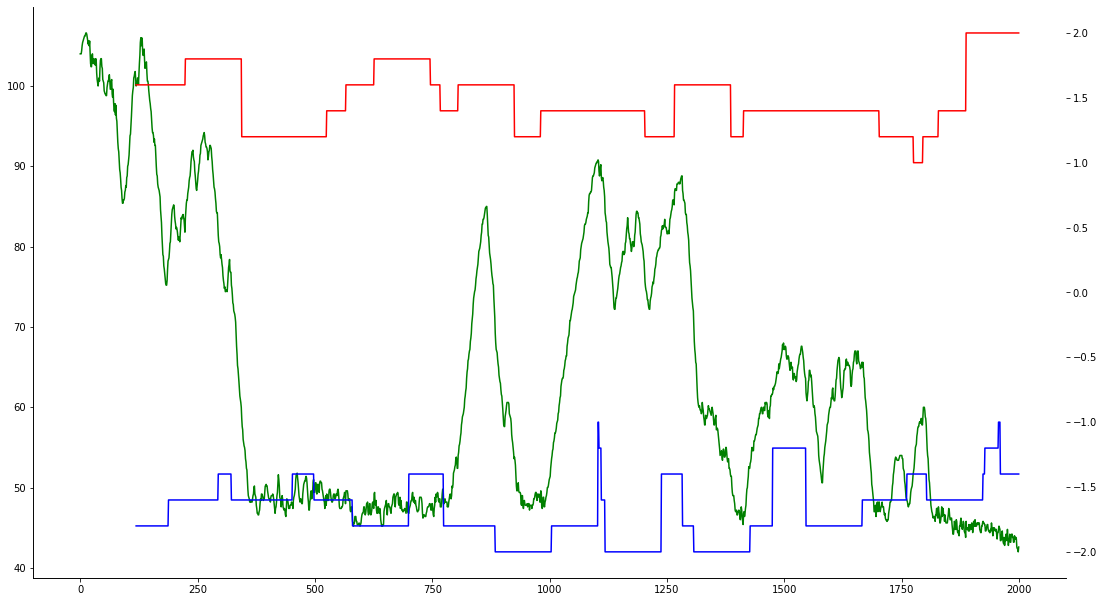

In [45]:
# Experiment with mean max and min on rolling elevation change
elv_period = 120
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax2 = ax1.twinx()
ax1.plot(df.index[0:2000],df['elevation'][0:2000], c='g')
# ax2.plot(df.index[0:2000],df['elevation_change'].rolling(60).mean()[0:2000], c='r')
ax2.plot(df.index[0:2000],df['elevation_change'].rolling(elv_period).max()[0:2000], c='r')
ax2.plot(df.index[0:2000],df['elevation_change'].rolling(elv_period).min()[0:2000], c='b')



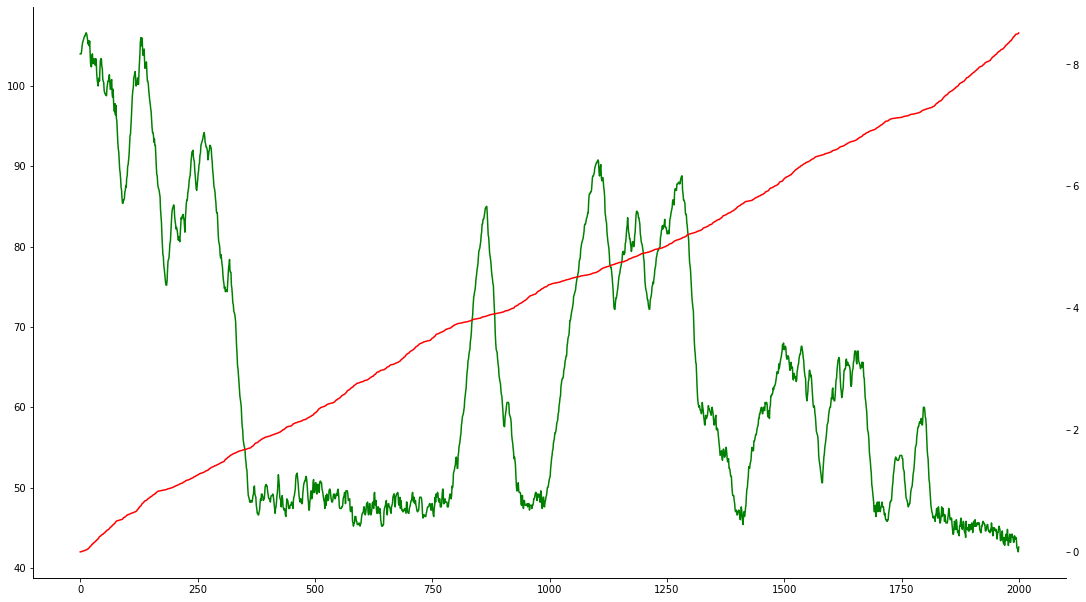

In [46]:
elv_period = 120
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax2 = ax1.twinx()
ax1.plot(df.index[0:2000],df['elevation'][0:2000], c='g')
# ax2.plot(df.index[0:2000],df['elevation_change'].rolling(60).mean()[0:2000], c='r')
ax2.plot(df.index[0:2000],df['cum_distance'][0:2000], c='r')

# Preserve changes in new CSV

In [47]:
df.to_csv('data/df_mile_segment.csv', index=False)
df.describe()

,latitude,longitude,elevation,distance,mph,elevation_change,cum_elevation,cum_distance,second,step_feet,moving_time,mile_num,grade_section
count,14965.000000,14965.000000,14965.000000,14965.000000,14965.000000,14965.000000,14965.000000,14965.000000,14965.000000,14965.000000,14965.000000,14965.000000,14965.000000
mean,38.749903,-77.381348,48.314053,0.003496,12.585372,-0.001483,-55.685947,26.817950,7482.000000,18.458546,0.993719,27.307584,268.676579
std,0.027657,0.045397,16.012795,0.003787,13.631423,0.671532,16.012795,14.410263,4320.167724,19.992753,0.079008,14.404311,144.097245
min,38.708129,-77.478967,17.600000,0.000000,0.000000,-28.200005,-86.400000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,38.726708,-77.414807,35.799999,0.001437,5.172588,-0.399994,-68.200001,15.515688,3741.000000,7.586462,1.000000,16.000000,156.000000
50%,38.742108,-77.383342,47.000000,0.002566,9.239364,0.000000,-57.000000,26.652905,7482.000000,13.551067,1.000000,27.000000,267.000000
75%,38.772272,-77.335727,58.200001,0.004546,16.364412,0.399998,-45.799999,38.250790,11223.000000,24.001138,1.000000,39.000000,383.000000
max,38.805451,-77.306468,106.599998,0.173349,624.057588,36.000000,2.599998,52.316694,14964.000000,915.284462,1.000000,53.000000,524.000000
